This is a more formalized folder to contain the ideas we have been working on. Let's keep it neat!

In [2]:
#import these before running lower block, some weird thing with environment, we'll figure it out...
import mne
import numpy
import matplotlib.pyplot as plt

0.24.1


In [5]:
#going to write a self contained function for windowing and processing pre-recorded data


#this function will be given a window in the form of an mne array and return a list of the dominant frequencies
def dominant_freq(window):
    #performs a power spectral display function on both the alpha and theta range
    psd_raw_alpha=numpy.array(mne.time_frequency.psd_multitaper(window,fmin=8,fmax=13,picks=["AF7","AF8","TP9","TP10"]))
    psd_raw_theta=numpy.array(mne.time_frequency.psd_multitaper(window,fmin=4,fmax=8,picks=["AF7","AF8","TP9","TP10"]))
####################################################################
    store = numpy.sum(psd_raw_alpha[0], axis=0)
    max_index=numpy.argmax(store)
    dominant_alpha= psd_raw_alpha[1]
    dominant_alpha= dominant_alpha[max_index]
####################################################################
    store = numpy.sum(psd_raw_theta[0], axis=0)
    max_index=numpy.argmax(store)
    dominant_theta= psd_raw_theta[1]
    dominant_theta= dominant_theta[max_index]

    

    return [dominant_alpha, dominant_theta]


#user will be the patient that we are working with, this will generate a distribution of dominant frequencies
#then we can work with the descriptive statistical measures from this distribution
def baseline(user):

    #defines some parameters to be used by the MNE library, specific to our recording setup
    info = mne.create_info(["timestamps","TP9","AF7","AF8", "TP10", "Right AUX"], 256, ch_types="eeg")

    #imports the raw recording data from the Data folder, 
    raw_recording = pandas.read_csv(str("Data/"+user+"_Baseline.csv"))
    print("Data imported...")
    #takes the raw recording and moves it into an MNE raw array object, allows for easier manipulation later
    #this is a different transformation than later as we are working with a Pandas object
    raw_array = mne.io.RawArray(raw_recording.values.T/1000000, info)
    print("Raw moved to raw_array...")
    #note that we are working with a setup recording at 256 Hz, thus a 256 time step sample represents one second
    step=0 #sets the start point of our window
    max=len(raw_array) #sets the max sample point of our recording
    distribution=[]
    alpha_dist = []
    theta_dist = []
    while step<max:
        #takes a one second sample from the raw recording, this is a numpy array though...
        raw_window=raw_array.get_data(picks=None, start=step,stop=(step+2048))
        #again moves this array into ane MNE raw array object            
        mne_window = mne.io.RawArray(raw_window, info)
        #advances the sample window forward by a second
        step=step+256
        #print("dominant alpha and theta freqs:", dominant_freq(mne_window))
        try:
            doms = dominant_freq(mne_window)
            alpha_dist.append(round(doms[0],3))
            theta_dist.append(round(doms[1],3))
        
        except ValueError:
            print("distributions generated...")


    return (alpha_dist, theta_dist)
        
        
alpha_dist, theta_dist = baseline("JacobLong1")

NameError: name 'pandas' is not defined

[8.0, 8.625, 8.75, 8.75, 8.75, 8.75, 9.125, 9.375, 9.375, 9.375, 9.375, 9.375, 9.375, 9.25, 9.125, 8.625, 8.0, 8.0, 9.0, 8.0, 8.5, 8.125, 8.0, 8.0, 8.125, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.125, 8.0, 8.0, 8.0, 12.125, 8.0, 8.75, 8.25, 8.375, 8.375, 8.625, 8.125, 8.125, 8.0, 8.25, 8.25, 8.25, 8.25, 8.25, 8.25, 8.125, 8.25, 8.125, 8.625, 8.625, 8.625, 8.0, 8.625, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.125, 8.0, 8.0, 8.0, 8.625, 8.75, 8.875, 8.5, 8.125, 8.625, 8.5, 8.125, 8.125, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.125, 8.0, 8.0, 8.625, 8.0, 8.125, 8.125, 8.0, 8.0, 8.0, 8.0, 8.0, 8.125, 8.125, 8.125, 8.25, 8.25, 8.125, 8.125, 8.25, 8.125, 8.25, 8.25, 8.0, 8.0, 8.0, 11.25, 11.25, 8.0, 11.25, 8.625, 9.0, 8.75, 8.875, 8.25, 8.375, 8.375, 8.375, 8.375, 8.625, 8.5, 8.125, 9.75, 8.125, 9.75, 9.75, 9.5, 9.5, 9.5, 8.75, 8.75, 8.75, 8.75, 8.0, 8.25, 8.125, 8.125, 8.25, 8.125, 8.125, 8.125, 8.0, 8.0, 8.375, 11.625, 11.5, 8.0, 10.25, 10.25, 8.0, 8.0,

Text(0.5, 0, 'Dominant Frequency')

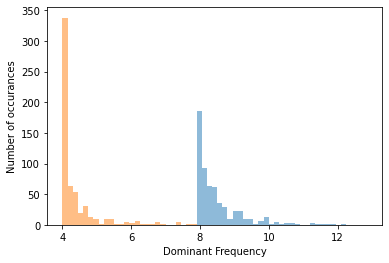

In [4]:
print(alpha_dist)
print(theta_dist)
bin_list = numpy.arange(4,13,.15) # fill in the function

fig = plt.figure()
plt.hist(alpha_dist,bin_list, alpha=0.5)
plt.hist(theta_dist,bin_list, alpha=0.5)


plt.ylabel('Number of occurances')
plt.xlabel('Dominant Frequency')

In [11]:
#this is all the code that Alex used to initialize the Muse stream and take live data

import numpy # Module that simplifies computations on matrices
import matplotlib.pyplot as plt  # Module used for plotting
from pylsl import StreamInlet, resolve_byprop  # Module to receive EEG data
import muselsl_utils as muselsl_utils  # Our own utility functions
import utils
import scipy.stats
import statistics
import time 


In [11]:
import utils
# Initialize the bluetooth stream to the Arduino
#this connects to the arduino, breaks 
#serial_port = serial.Serial("COM4", baudrate=9600, timeout=10)
#serial_port.flushInput()
# Handy little enum to make code more readable
class Band:
    Delta = 0
    Theta = 1
    Alpha = 2
    Beta = 3

blink_types = ["Right Wink", "Left Wink", "Normal Blink", "Nothing"]

""" EXPERIMENTAL PARAMETERS """
# Modify these to change aspects of the signal processing

# Length of the EEG data buffer (in seconds)
# This buffer will hold last n seconds of data and be used for calculations
BUFFER_LENGTH = 10

# This is the batch size that out code will grab from the buffer when it is ready to process the new data
EPOCH_LENGTH = 4

# Amount of overlap between two consecutive epochs (in seconds)
OVERLAP_LENGTH = 0

# Amount to 'shift' the start of each next consecutive epoch
SHIFT_LENGTH = EPOCH_LENGTH - OVERLAP_LENGTH

# Index of the channel(s) (electrodes) to be used
# 0 = left ear, 1 = left forehead, 2 = right forehead, 3 = right ear
INDEX_CHANNEL = [0, 1, 2, 3]

if __name__ == "__main__":

    """ 1. CONNECT TO EEG STREAM """

    # Search for active LSL streams
    print('Looking for an EEG stream...')
    streams = pylsl.resolve_byprop('type', 'EEG', timeout=2)
    if len(streams) == 0:
        raise RuntimeError('Can\'t find EEG stream.')

    # Set active EEG stream to inlet and apply time correction
    print("Start acquiring data")
    inlet = StreamInlet(streams[0], max_chunklen=12)
    eeg_time_correction = inlet.time_correction()

    # Get the stream info and description
    info = inlet.info()
    description = info.desc()

    # Get the sampling frequency
    # This is an important value that represents how many EEG data points are
    # collected in a second. This influences our frequency band calculation.
    # for the Muse 2016, this should always be 256
    fs = int(info.nominal_srate())

    """ 2. INITIALIZE BUFFERS """

    # Initialize raw EEG data buffer - 256*5 x 4 array to store the last 5 seconds
    eeg_buffer = numpy.zeros((int(fs * BUFFER_LENGTH), 4))
    filter_state = None  # for use with the notch filter

    # Compute the number of epochs in "buffer_length"
    n_win_test = int(numpy.floor((BUFFER_LENGTH - EPOCH_LENGTH) /
                              SHIFT_LENGTH + 1))

    # Initialize the band power buffer (for plotting)
    # bands will be ordered: [delta, theta, alpha, beta]
    band_buffer = numpy.zeros((n_win_test, 4))

    """ 3. GET DATA """
    info = mne.create_info(["TP9","AF7","AF8", "TP10"], 256, ch_types="eeg")
    # The try/except structure allows to quit the while loop by aborting the
    # script with <Ctrl-C>
    print('Press Ctrl-C in the console to break the while loop.')

    a_store=[]
    t_store=[]
    try:
        counter=0
        # The following loop acquires data, computes band powers, and calculates neurofeedback metrics based on those band powers
        while True:
            time.sleep(4)
            """ 3.1 ACQUIRE DATA """
            # Obtain EEG data from the LSL stream
            eeg_data, timestamp = inlet.pull_chunk(
                timeout=1, max_samples=int(SHIFT_LENGTH * fs))


            # Only keep the channel we're interested in
            ch_data = numpy.array(eeg_data)[:, 0:4]

            # Update EEG buffer with the new data
            #this eeg_buffer is a 5 second store of data, sampled at 256 Hz, it is a numpy array
            eeg_buffer, filter_state = muselsl_utils.update_buffer(
                eeg_buffer, ch_data, notch=False,
                filter_state=filter_state)
            
            if eeg_buffer[0,0] != 0:

                """ 3.2 COMPUTE BAND POWERS """
                # Get newest samples from the buffer
                data_epoch = muselsl_utils.get_last_data(eeg_buffer,
                                             EPOCH_LENGTH * fs)
            
                data_epoch = numpy.transpose(data_epoch)
                mne_epoch = mne.io.RawArray(data_epoch, info)
            
                freqs = dominant_freq(mne_epoch)

                if len(a_store) == 60:
                    a_store.pop(0) 
                    a_store.append(round(freqs[0],3))
                else:
                    a_store.append(round(freqs[0],3))
            
                if len(t_store) == 60:
                    t_store.pop(0) 
                    t_store.append(round(freqs[0],3))
                else:
                    t_store.append(round(freqs[1],3))
                print((a_store))
                

            if len(a_store)==60: ####FIX THIS IN POST
                ap = scipy.stats.mannwhitneyu(x=a_store,y=alpha_dist, use_continuity=True, alternative='less', axis=0, method='auto')
                tp = scipy.stats.mannwhitneyu(x=t_store,y=theta_dist, use_continuity=True, alternative='less', axis=0, method='auto')
                if ap[1]+tp[1] < 0.05:
                    print("The patient is experiencing nicotwithdrawal, p-val = ", ap[1]+tp[1])
                    state = 1
                else:
                    print("The patient is not experiencing nicotwithdrawal, p-val = ", ap[1]+tp[1])
                    state = 0 

            
                        
                    
            #data_epoch=data_epoch.transpose
            #raw_array = mne.io.RawArray(data_epoch, info)

            #commenting this out for now, not sure what it does, but pretty sure we dont need it
            #print('Alpha Relaxation: ', alpha_metric)
            #x = utils.compute_features(data_epoch, filter=None, pca=None, use_original=True)
            #probabilities = classifier.predict_proba([x])
           # if np.any(probabilities > 0.8): 
               # print(f"\r{blink_types[np.argmax(probabilities)]} : {probabilities.max()}")
               # serial_port.write(bytes(str(np.argmax(probabilities)), encoding='utf-8'))

            # Beta Protocol:
            # Beta waves have been used as a measure of mental activity and concentration
            # This beta over theta ratio is commonly used as neurofeedback for ADHD
            # beta_metric = smooth_band_powers[Band.Beta] / \
            #     smooth_band_powers[Band.Theta]
            # print('Beta Concentration: ', beta_metric)

            # Alpha/Theta Protocol:
            # This is another popular neurofeedback metric for stress reduction
            # Higher theta over alpha is supposedly associated with reduced anxiety
            # theta_metric = smooth_band_powers[Band.Theta] / \
            #     smooth_band_powers[Band.Alpha]
            # print('Theta Relaxation: ', theta_metric)

    except KeyboardInterrupt:
        #serial_port.close()
        print('Closing!')

Looking for an EEG stream...


NameError: name 'pylsl' is not defined

In [9]:
print(jedi.__version__)


NameError: name 'jedi' is not defined